In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

#### Double Conv

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),) 

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)  # Notice there's no non-linear here; there's a nn.SiLU in the next layer             




**group-norm**: channels are separated into several groups before mean and std dev is taken over each group.   
`nn.GroupNorm(num_group, num_of_channel)`: in this case, as num_group is 1, the channels are not split into group, so `nn.GroupNorm` == `nn.LayerNorm`

![group-norm](https://amaarora.github.io/images/GN_BN_LN_IN.png)

**gelu**  


<img src="https://i.stack.imgur.com/tJI3j.png" width=25% height=25%>

#### Self Attention

In [7]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True) # channels = embedding dim, nheads = 4
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

**1) reshape input tensor**  
  - `x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)`
    - size comes from `SelfAttention(channel, size)`
    - swap axis: (bs, 3, 256, 256) >>> (bs,3, (256\*256)) >>>  (bs, (256\*256), 3)  


**2) layernorm** [~ doc](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html)     
  - `self.ln = nn.LayerNorm([channels])`
  - `x_ln = self.ln(x)` 
    - normalize over channel axis (eg RGB channels for original image)
      - note that if normalizing over 3 axes Channel,Ht,Wd it would be
        - `layer_norm = nn.LayerNorm([C, H, W])` instead of `nn.LayerNorm([C])`
        - eg nn.LayerNorm([3, 256, 256])

**3) multi-head attention**[~ doc](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html?highlight=multihead#torch.nn.MultiheadAttention)

- `nn.MultiheadAttention(channels, nheads,batch_first=True)`  
  - d_model = embedding dimension = channels  
    - channels could be 64, 128, 256 or 512 depending on where we are in the Unet
    - but must be divisible by 4 since there are 4 heads

- `self.mha(x_layered_norm, x_layered_norm, x_layered_norm)`
  - $Attention(Q, K, V)$
  - $Q$ = (bs, (256X256), 64) eg
  - $W^{Q}$ = (64 X 64) 
  - $Q \times W^{Q}$ = (bs, (256X256), 64)

- `attn_output, attn_output_weights = multihead_attn(query, key, value)`  
  - `attn_output`: size = (bs, seq_len, embedding_dim); in this case its (bs, ht*wd, channels)

**4) residual connection**
  - `attention_value = attention_value + x` 

**5) feedforward layer**
  - `attention_value = self.ff_self(attention_value) + attention_value` # why add attention value again?
    - nn.LayerNorm([channels])
    - nn.Linear(channels, channels)
    - nn.GELU()
    - nn.Linear(channels, channels)  
    
**6) reshape back to (bs, channel, ht, wd)**
  - `attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)`    



#### positional encoding  
$\frac{1}{n^{2i/d}}$ = `1.0 / (10000** (torch.arange(0, n, 2).float() / n))` 

In [5]:
def pos_encoding(k, n):
    denominator = 1.0 / (10000** (torch.arange(0, n, 2).float() / n))
    pos_enc_a = torch.sin(k.repeat(1, n // 2) * denominator)
    pos_enc_b = torch.cos(k.repeat(1, n // 2) * denominator)
    pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
    return pos_enc

**torch.repeat**: e.g. `x.repeat(2,3)` repeat a tensor in axis0 2 times and axis1 3 times 

In [54]:
x = torch.tensor([1,2,3])
print(x.size())
print(x.repeat(1), x.repeat(1).size())
print(x.repeat(1,2), x.repeat(1,2).size())
print(x.repeat(2,2), x.repeat(2,2).size())

torch.Size([3])
tensor([1, 2, 3]) torch.Size([3])
tensor([[1, 2, 3, 1, 2, 3]]) torch.Size([1, 6])
tensor([[1, 2, 3, 1, 2, 3],
        [1, 2, 3, 1, 2, 3]]) torch.Size([2, 6])


<img src="https://machinelearningmastery.com/wp-content/uploads/2022/01/PE2.png" width=50% height=50%>   

$\frac{k}{n^{2i/d}}$

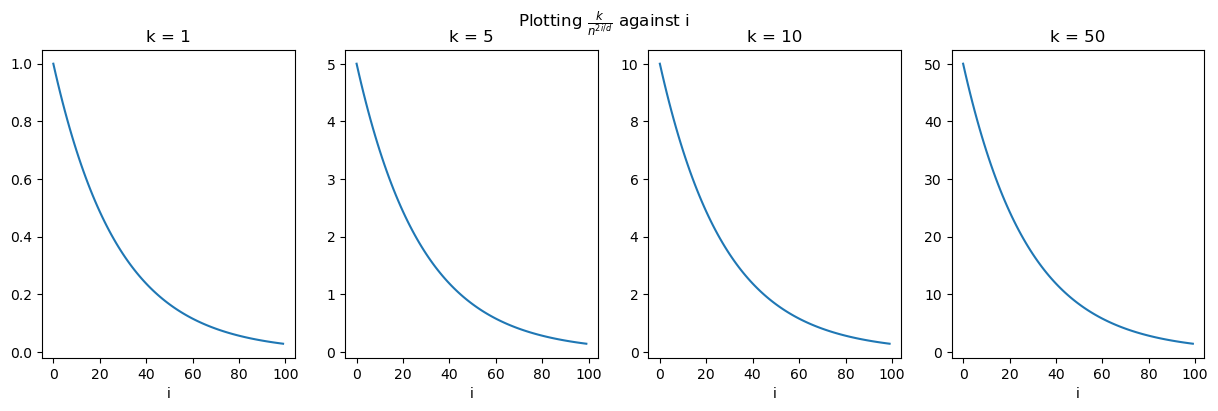

In [146]:

def plot_k_denominator(k, d=512, n=10000):
    i = np.arange(0, 100, 1)
    denominator = np.power(n, 2*i/d)
    y = k/denominator
    plt.plot(i, y)
    plt.title('k = ' + str(k))
    plt.xlabel("i")

fig = plt.figure(figsize=(15, 4))    
plt.suptitle("Plotting $\\frac{k}{n^{2i/d}}$ against i")
k = [1,5,10,50]
for i in range(4):
    plt.subplot(141 + i)
    plot_k_denominator(k[i])

$Positional Embedding(k, 2i) = \sin(\frac{k}{n^{2i/d}})$

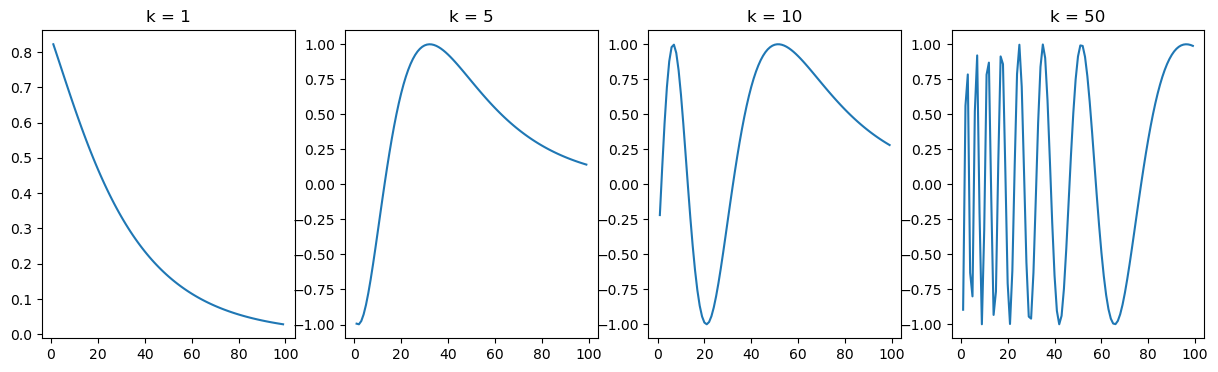

In [157]:
def plotSinusoid(k, d=512, n=10000):
    i = np.arange(1, 100, 1)
    denominator = np.power(n, 2*i/d)
    y = np.sin(k/denominator)
    plt.plot(i, y)
    plt.title('k = ' + str(k))

 
fig = plt.figure(figsize=(15, 4))    
k = [1,5,10,50]
for i in range(4):
    plt.subplot(141 + i)
    plotSinusoid(k[i])

$Positional Embedding(k, 2i+1) = \cos(\frac{k}{n^{2i/d}})$

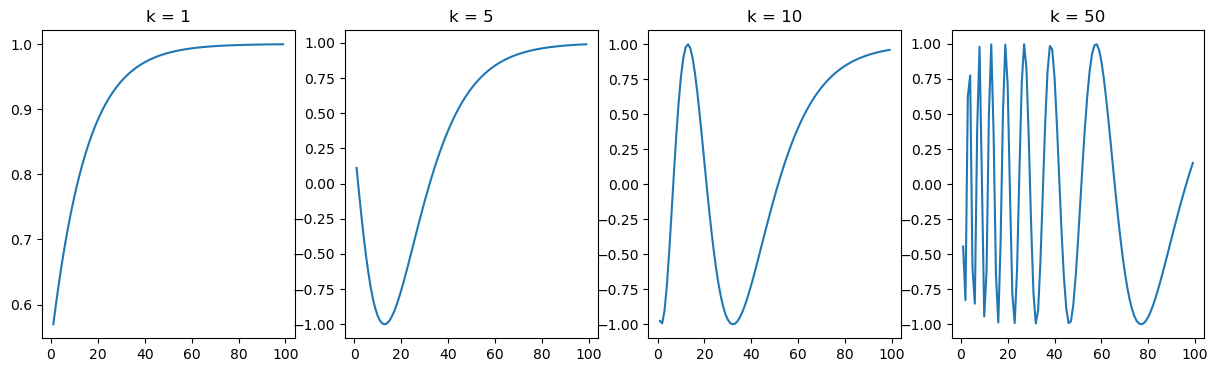

In [139]:

def plotSinusoid(k, d=512, n=10000):
    i = np.arange(1, 100, 1)
    denominator = np.power(n, 2*i/d)
    y = np.cos(k/denominator)
    plt.plot(i, y)
    plt.title('k = ' + str(k))
 
fig = plt.figure(figsize=(15, 4))    
k = [1,5,10,50]
for i in range(4):
    plt.subplot(141 + i)
    plotSinusoid(k[i])


#### Unet

In [4]:
class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)  

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output


#### Downblock

In [3]:

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb



**1) maxpool + double conv + double conv**
  - maxpool: reduce ht and wd by half
  - pass through two double conv
    - conv2d >> groupnorm >> gelu >> conv2d >> groupnorm >> residual connection
  - number of channels increases from `in_channels` to `out_channels`

**2) convert dimension of time $t$ from embedding to `out_channels`**    
  - $t$ (bs,1) `>>` positional_encoding >> (bs,256) `>>` Silu `>>` Linear(embedding, out_channel)  # 256=time dimension, predetermined by author outlier

  
**3) repeat $t$ from size (bs, 256) to (bs. 256, ht, wd)**  
  - `t[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])`
    - could have just used automatic broadcasting by reshaping t to be t[:, :, None, None] rather than repeat?

**4) add time $t$ to image**
  - `x + emb`  
      

Side-note: could have just used automatic broadcasting (see below) by reshaping t to be `t[:, :, None, None]` rather than use `.repeat()`?

In [47]:
x = torch.randn(8,3,64,64);print(x.shape)
t = torch.tensor([[1000,1000,1000]]*8); print(t.shape)
t = t[:, :, None, None]; z = (x+t); z.shape

torch.Size([8, 3, 64, 64])
torch.Size([8, 3])


torch.Size([8, 3, 64, 64])

#### Upblock

In [27]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


**1) upsample**
  - upsample by scale 2: ht X 2 , wd X 2


**2) concat with skip connection**
  -  `x = torch.cat([skip_x, x], dim=1)` 

**3) double conv + double conv**  
  - pass through two double conv
    - conv2d >> groupnorm >> gelu >> conv2d >> groupnorm >> residual connection
    - 2nd double-conv is a bottle-neck
      - in_channels `>>` in_channels // 2 `>>` out_channels 
  - number of channels increase from `in_channels` to `out_channels`

**4) convert dimension of time $t$ from embedding to `out_channels`**    
  - $t$ (bs,1) `>>` positional_encoding(bs,256) `>>` Silu `>>` Linear(embedding, out_channel)  # why chose time-dim to be 256?

  
**5) repeat $t$ from size (bs, 256) to (bs. 256, ht, wd)**  
  - `t[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])`


**6) add time $t$ to image**
  - `x + emb`  


Upsample Example

In [48]:
 input = torch.arange(1, 5, dtype=torch.float32).view(1,1, 2, 2);input # bilinear requires 4D tensor

tensor([[[[1., 2.],
          [3., 4.]]]])

In [49]:
m = nn.Upsample(scale_factor=2, mode='bilinear')  # Upsample only works for 3D and above
m(input)

tensor([[[[1.0000, 1.2500, 1.7500, 2.0000],
          [1.5000, 1.7500, 2.2500, 2.5000],
          [2.5000, 2.7500, 3.2500, 3.5000],
          [3.0000, 3.2500, 3.7500, 4.0000]]]])

In [50]:
m = nn.Upsample(scale_factor=3, mode='bilinear')  
m(input)

tensor([[[[1.0000, 1.0000, 1.3333, 1.6667, 2.0000, 2.0000],
          [1.0000, 1.0000, 1.3333, 1.6667, 2.0000, 2.0000],
          [1.6667, 1.6667, 2.0000, 2.3333, 2.6667, 2.6667],
          [2.3333, 2.3333, 2.6667, 3.0000, 3.3333, 3.3333],
          [3.0000, 3.0000, 3.3333, 3.6667, 4.0000, 4.0000],
          [3.0000, 3.0000, 3.3333, 3.6667, 4.0000, 4.0000]]]])

#### Unet

In [46]:

class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):
        pass

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)
                                        # x = (bs,3,64,64)
        x1 = self.inc(x)                # DoubleConv(3, 64)     |(bs,64,64,64) | (in_channel,out_channel)  
        x2 = self.down1(x1, t)          # Down(64, 128)         |(bs,128,32,32)| (in_channel,out_channel)|  
        x2 = self.sa1(x2)               # SelfAttention(128, 32)|(bs,128,32,32)| (channel,size) size=ht,size=wd
        x3 = self.down2(x2, t)          # Down(128, 256)        |(bs,256,16,16)    
        x3 = self.sa2(x3)               # SelfAttention(256, 16)|(bs,256,16,16)
        x4 = self.down3(x3, t)          # Down(256, 256)        |(bs,256,8,8)
        x4 = self.sa3(x4)               # SelfAttention(256, 8) |(bs,256,8,8)

        x4 = self.bot1(x4)              # DoubleConv(256, 512)  |(bs,512,8,8)
        x4 = self.bot2(x4)              # DoubleConv(512, 512)  |(bs,512,8,8)
        x4 = self.bot3(x4)              # DoubleConv(512, 256)  |(bs,256,8,8)


        x = self.up1(x4, x3, t)         # Up(512, 128)          |(bs,128,16,16)|concat(x3,x4)=512 though x3=x4=256
        x = self.sa4(x)                 # SelfAttention(128, 16)|(bs,128,16,16)
        x = self.up2(x, x2, t)          # Up(256, 64)           |(bs,64,32,32)|concat(x,x2)=256 though x=x2=128 
        x = self.sa5(x)                 # SelfAttention(64, 32) |(bs,64,32,32)
        x = self.up3(x, x1, t)          # Up(128, 64)           |(bs,64,64,64)|concat(x,x1)= 64 though x=x1=32 
        x = self.sa6(x)                 # SelfAttention(64, 64) |(bs,64,64,64)
        output = self.outc(x)           # nn.Conv2d(64, 3, ks=1)|(bs,3,64,64) 
        return output                   # output = (bs,3,64,64)